In [ ]:
# get formating done automatically according to style `black`
# %load_ext lab_black

In [20]:
# Setup a dask cluster
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()

cluster.adapt(minimum=1,maximum=8)

cluster.scale(4)

In [ ]:
client = Client(cluster)
client

---

In [1]:
# Import some python libraries
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import intake

In [ ]:
# should be >= 2019.12.13
import intake_esm
intake_esm.__version__

# `intake-esm`
intake-esm.readthedocs.io/
check out available cloud datasets here: `github.com/NCAR/intake-esm-datastore/master/catalogs/`

# CMIP6

In [ ]:
# json file contains the rules for concat and merge as well as the location for the catalog .csv file
col = intake.open_esm_datastore("https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json")

# col.df is a pandas.DataFrame: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame
col.df.head()

In [ ]:
# overview of available keys and accepted values
uni_dict = col.unique(["source_id", "institution_id", "table_id", "experiment_id"])
# pprint.pprint(uni_dict, compact=True)

In [ ]:
# quick check by hand
# col.df.source_id.unique()

## GMST MPI-ESM-LR plot

In [23]:
cat = col.search(variable_id='ta',
                 experiment_id='historical',
                 table_id='Amon',
                 source_id='MPI-ESM1-2-LR',
                 member_id='r1i1p1f1')
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,Amon,ta,gn,gs://cmip6/CMIP/MPI-M/MPI-ESM1-2-LR/historical...,NaN


In [24]:
# this gets xr.Datasets from netcdf files with `dask`
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 12*50}},
                                preprocess=None)
# show the list of available xr.Datasets
list(dset_dict)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 1 group(s)


['CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn']

In [25]:
# get first item
_,ds = dset_dict.popitem()
# extract xr.dataArray
da = ds['ta'].squeeze()

# lazy data
da.data

dask.array<getitem, shape=(1980, 19, 96, 192), dtype=float32, chunksize=(91, 19, 96, 192), chunktype=numpy.ndarray>

In [26]:
da = da.isel(plev=0)

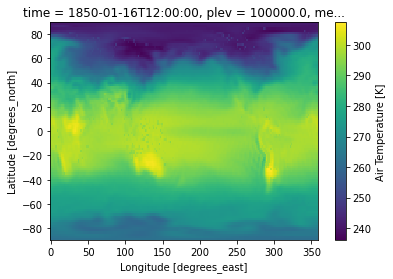

In [27]:
da.isel(time=0).plot()

In [ ]:
da_gm = da.mean(['lon','lat']).load()

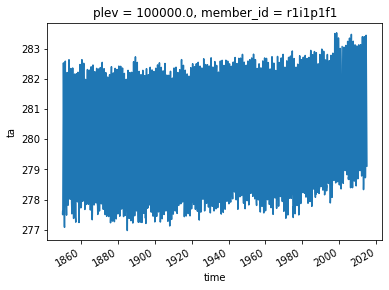

In [29]:
da_gm.plot()

In [30]:
def yearmean(ds,dim='time'):
    return ds.groupby(f'{dim}.year').mean().rename({'year':dim})

distributed.scheduler - INFO - Register worker <Worker 'tcp://10.48.143.2:39081', name: 1, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.48.143.2:39081
distributed.core - INFO - Starting established connection


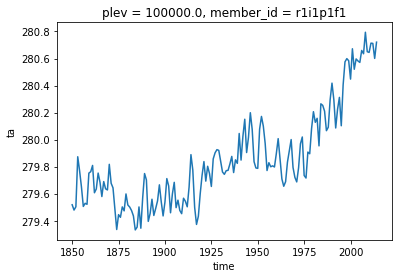

distributed.scheduler - INFO - Retire worker names (2,)
distributed.scheduler - INFO - Retire workers {<Worker 'tcp://10.48.124.3:46079', name: 2, memory: 0, processing: 0>}
distributed.scheduler - INFO - Closing worker tcp://10.48.124.3:46079
distributed.scheduler - INFO - Remove worker <Worker 'tcp://10.48.124.3:46079', name: 2, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.48.124.3:46079
distributed.deploy.adaptive - INFO - Retiring workers [2]


In [31]:
yearmean(da_gm).plot()

## multiple models
now SST

In [32]:
variable = "tos"
query = dict(
    experiment_id="historical",
    table_id="Omon",
    member_id="r1i1p1f1",
    variable_id=variable,
    grid_label="gn",
)
cat = col.search(**query)
# subselect a few models
models = list(cat.df.source_id.unique())[::5]
print(f"models choosen: {models}")
# refine search for these models
cat = cat.search(source_id=models)
cat.df.head()

models choosen: ['AWI-CM-1-1-MR', 'CanESM5', 'E3SM-1-1', 'MIROC6', 'GISS-E2-1-H', 'KACE-1-0-G', 'MCM-UA-1-0']


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r...,NaN
1,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP/CCCma/CanESM5/historical/r1i1p...,NaN
2,CMIP,E3SM-Project,E3SM-1-1,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP/E3SM-Project/E3SM-1-1/historic...,NaN
3,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP/MIROC/MIROC6/historical/r1i1p1...,NaN
4,CMIP,NASA-GISS,GISS-E2-1-H,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP/NASA-GISS/GISS-E2-1-H/historic...,NaN


In [34]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 12*50}})
list(dset_dict)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 7 group(s)


distributed.scheduler - INFO - Receive client connection: Client-worker-ee217e4c-6d0a-11ea-802b-b2d4ae05d3bc
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-ee6758ba-6d0a-11ea-802b-d292c5886775
distributed.core - INFO - Starting established connection


['CMIP.AWI.AWI-CM-1-1-MR.historical.Omon.gn',
 'CMIP.CCCma.CanESM5.historical.Omon.gn',
 'CMIP.E3SM-Project.E3SM-1-1.historical.Omon.gr',
 'CMIP.MIROC.MIROC6.historical.Omon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-H.historical.Omon.gn',
 'CMIP.NIMS-KMA.KACE-1-0-G.historical.Omon.gr',
 'CMIP.UA.MCM-UA-1-0.historical.Omon.gn']

In [35]:
model_list = []
da_list = []
for key, value in dset_dict.items():
    print(key, dset_dict[key][variable].coords)
    da = dset_dict[key][variable].squeeze()
    display(da.data)
    spatial_dims = [dim for dim in da.dims if dim != "time"]
    da_gm = da.mean(spatial_dims)
    # setting time identical
    da_gm = da_gm.sortby("time")
    da_gm["time"] = xr.cftime_range(start="1850", freq="MS", periods=da_gm.time.size)
    # triggers computation for debugging sometime earlier needed as here
    # da_gm = da_gm.compute()
    da_list.append(da_gm)
    model = key.split(".")[2]
    model_list.append(model)

CMIP.AWI.AWI-CM-1-1-MR.historical.Omon.gn Coordinates:
    lat        (ncells) float64 dask.array<chunksize=(830305,), meta=np.ndarray>
    lon        (ncells) float64 dask.array<chunksize=(830305,), meta=np.ndarray>
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'


,Array,Chunk
Bytes,6.58 GB,79.71 MB
Shape,"(1980, 830305)","(24, 830305)"
Count,250 Tasks,83 Chunks
Type,float32,numpy.ndarray


distributed.scheduler - INFO - Register worker <Worker 'tcp://10.48.112.3:38489', name: 4, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.48.112.3:38489
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://10.48.113.3:42329', name: 3, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.48.113.3:42329
distributed.core - INFO - Starting established connection


CMIP.CCCma.CanESM5.historical.Omon.gn Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y          (y) float64 -78.39 -78.19 -77.98 -77.77 ... 71.57 71.62 71.65
  * member_id  (member_id) <U8 'r1i1p1f1'


dask.array<getitem, shape=(1980, 291, 360), dtype=float32, chunksize=(215, 291, 360), chunktype=numpy.ndarray>

CMIP.E3SM-Project.E3SM-1-1.historical.Omon.gr Coordinates:
    lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'


dask.array<getitem, shape=(1980, 180, 360), dtype=float32, chunksize=(325, 180, 360), chunktype=numpy.ndarray>

CMIP.MIROC.MIROC6.historical.Omon.gn Coordinates:
    lat        (y, x) float32 dask.array<chunksize=(256, 360), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(256, 360), meta=np.ndarray>
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y          (y) float32 -88.0 -85.75 -85.25 ... 78.00103 78.0676 78.106964
  * member_id  (member_id) <U8 'r1i1p1f1'


dask.array<getitem, shape=(1980, 256, 360), dtype=float32, chunksize=(312, 256, 360), chunktype=numpy.ndarray>

CMIP.NASA-GISS.GISS-E2-1-H.historical.Omon.gn Coordinates:
    lon        (x, y) float64 1.25 1.25 1.25 1.25 ... 358.8 358.8 358.8 358.8
    lat        (x, y) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * x          (x) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * y          (y) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'


dask.array<getitem, shape=(1980, 90, 144), dtype=float32, chunksize=(963, 90, 144), chunktype=numpy.ndarray>

CMIP.NIMS-KMA.KACE-1-0-G.historical.Omon.gr Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(200, 360), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(200, 360), meta=np.ndarray>
  * time       (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
  * x          (x) float64 80.5 80.5 80.5 80.5 80.5 ... 81.5 81.5 81.5 81.5 81.5
  * y          (y) float64 -81.5 -81.5 -81.5 -81.5 ... -81.5 -81.5 -81.5 -81.5
  * member_id  (member_id) <U8 'r1i1p1f1'


dask.array<getitem, shape=(1980, 200, 360), dtype=float32, chunksize=(171, 200, 360), chunktype=numpy.ndarray>

CMIP.UA.MCM-UA-1-0.historical.Omon.gn Coordinates:
    lon        (x, y) float64 0.9375 0.9375 0.9375 0.9375 ... 359.1 359.1 359.1
    lat        (x, y) float64 -88.63 -86.13 -83.88 -81.63 ... 83.88 86.13 88.63
  * x          (x) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * y          (y) float64 -88.63 -86.13 -83.88 -81.63 ... 83.88 86.13 88.63
  * time       (time) object 1850-01-17 00:00:00 ... 2014-12-17 00:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'


dask.array<getitem, shape=(1980, 80, 192), dtype=float32, chunksize=(1626, 80, 192), chunktype=numpy.ndarray>

In [36]:
da = xr.concat(da_list,dim='model')
da['model'] = model_list
da

In [36]:
# trigger computation
da = da.load()

In [37]:
# annual means
da_ym = yearmean(da)

distributed.scheduler - INFO - Retire worker names (3, 4)
distributed.scheduler - INFO - Retire workers {<Worker 'tcp://10.48.113.3:42329', name: 3, memory: 0, processing: 0>, <Worker 'tcp://10.48.112.3:38489', name: 4, memory: 0, processing: 0>}
distributed.scheduler - INFO - Closing worker tcp://10.48.112.3:38489
distributed.scheduler - INFO - Remove worker <Worker 'tcp://10.48.112.3:38489', name: 4, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.48.112.3:38489
distributed.scheduler - INFO - Closing worker tcp://10.48.113.3:42329
distributed.scheduler - INFO - Remove worker <Worker 'tcp://10.48.113.3:42329', name: 3, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.48.113.3:42329
distributed.deploy.adaptive - INFO - Retiring workers [3, 4]


Text(0.5, 1.0, 'GMOST')

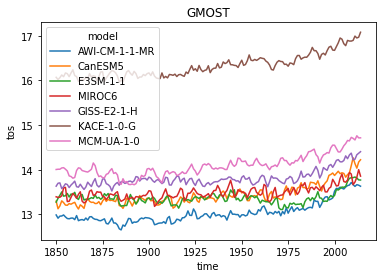

In [38]:
da_ym.plot(hue='model')
plt.title('GMOST')

In [39]:
start,end=1960,1990
da_ym_anom = da_ym-da_ym.sel(time=slice(start,end)).mean('time')

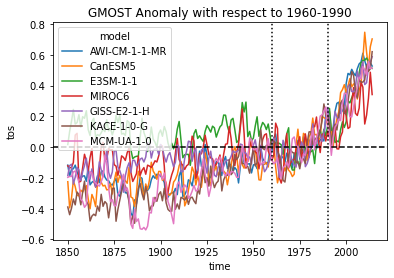

In [40]:
da_ym_anom.plot(hue='model')
for x in [start,end]:
    plt.axvline(x=x,c='k',ls=':')
plt.axhline(y=0,c='k',ls='--')
plt.title(f'GMOST Anomaly with respect to {start}-{end}')
plt.show()

## many experiments all having the same model available

Imagine you want to check whether GMST has different variability when CO$_2$ is prescribed (`piControl`) or prognostic (`esm-piControl`). So you only find models which provide output for both simulations.

`require_all_on` is your friend.

In [ ]:
cat = col.search(experiment_id=["esm-piControl", "piControl"],
    require_all_on="source_id",
    variable_id="tas",
    table_id="Amon")
cat.df.head()

In [ ]:
cat.df.source_id.unique()

## advanced

### spatial plotting

On ocean grid there are all sorts of dimension and coordinate names: `(i,j)`, `(x,y)`, `(xc,yc)`, `(lon,lat)`.

`cmip6_preprocessing` tries to correct many of these inhomogenities. Particularly useful for (ocean) multi-model comparisons.

Credits to Julius Busecke for creating `cmip6_preprocessing`: https://github.com/jbusecke/cmip6_preprocessing

In [41]:
import cartopy.crs as ccrs
import cartopy as cp

from cmip6_preprocessing.preprocessing import combined_preprocessing
# combined_preprocessing??

In [42]:
variable='fgco2'
cat = col.search(experiment_id='esm-piControl', table_id='Omon',
             variable_id=variable)
# sometimes a model crashes
models = list(col.df.source_id.unique())
models.remove('GFDL-ESM4')
cat = cat.search(source_id=models)
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,CMIP,BCC,BCC-CSM2-MR,esm-piControl,r1i1p1f1,Omon,fgco2,gn,gs://cmip6/CMIP/BCC/BCC-CSM2-MR/esm-piControl/...,NaN
1,CMIP,CCCma,CanESM5,esm-piControl,r1i1p1f1,Omon,fgco2,gn,gs://cmip6/CMIP/CCCma/CanESM5/esm-piControl/r1...,NaN
2,CMIP,CNRM-CERFACS,CNRM-ESM2-1,esm-piControl,r1i1p1f2,Omon,fgco2,gn,gs://cmip6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/esm-p...,NaN
3,CMIP,NCAR,CESM2,esm-piControl,r1i1p1f1,Omon,fgco2,gn,gs://cmip6/CMIP/NCAR/CESM2/esm-piControl/r1i1p...,NaN
4,CMIP,NCAR,CESM2,esm-piControl,r1i1p1f1,Omon,fgco2,gr,gs://cmip6/CMIP/NCAR/CESM2/esm-piControl/r1i1p...,NaN


In [43]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 12*50}},
                                preprocess=combined_preprocessing)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 6 group(s)


distributed.scheduler - INFO - Register worker <Worker 'tcp://10.48.114.3:35541', name: 4, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.48.114.3:35541
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://10.48.121.3:43087', name: 5, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.48.121.3:43087
distributed.core - INFO - Starting established connection


Processing CMIP.BCC.BCC-CSM2-MR.esm-piControl.Omon.gn


distributed.scheduler - INFO - Register worker <Worker 'tcp://10.48.121.4:36839', name: 6, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.48.121.4:36839
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://10.48.122.4:32827', name: 7, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.48.122.4:32827
distributed.core - INFO - Starting established connection


Processing CMIP.CCCma.CanESM5.esm-piControl.Omon.gn
Processing CMIP.CNRM-CERFACS.CNRM-ESM2-1.esm-piControl.Omon.gn
Processing CMIP.NCAR.CESM2.esm-piControl.Omon.gn
Processing CMIP.NCAR.CESM2.esm-piControl.Omon.gr
Processing CMIP.NCC.NorESM2-LM.esm-piControl.Omon.gn


/srv/conda/envs/notebook/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


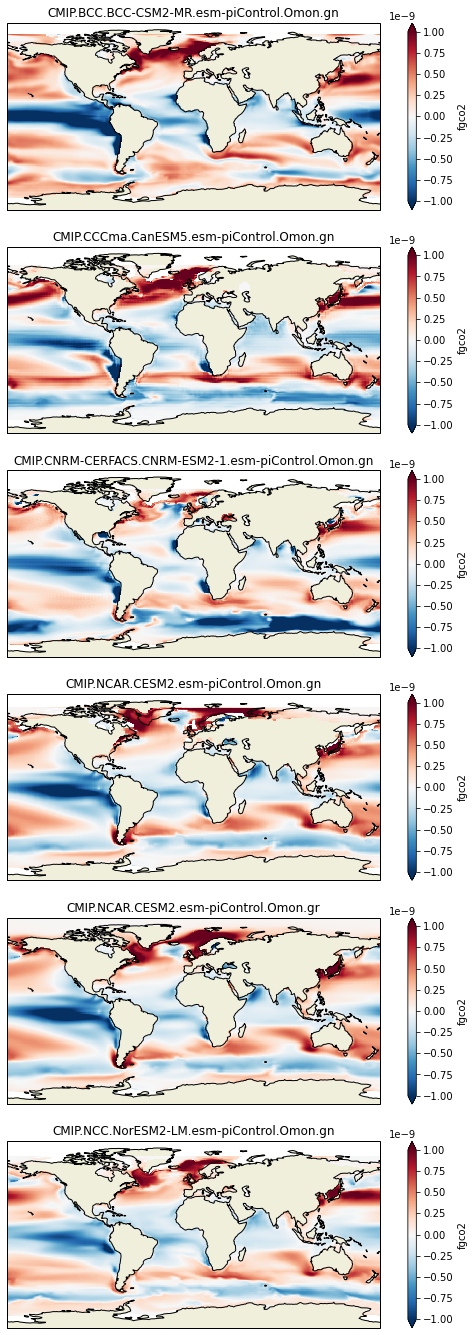

distributed.scheduler - INFO - Retire worker names (6, 7)
distributed.scheduler - INFO - Retire workers {<Worker 'tcp://10.48.121.4:36839', name: 6, memory: 0, processing: 0>, <Worker 'tcp://10.48.122.4:32827', name: 7, memory: 0, processing: 0>}
distributed.scheduler - INFO - Closing worker tcp://10.48.122.4:32827
distributed.scheduler - INFO - Remove worker <Worker 'tcp://10.48.122.4:32827', name: 7, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.48.122.4:32827
distributed.scheduler - INFO - Closing worker tcp://10.48.121.4:36839
distributed.scheduler - INFO - Remove worker <Worker 'tcp://10.48.121.4:36839', name: 6, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.48.121.4:36839
distributed.deploy.adaptive - INFO - Retiring workers [6, 7]


In [45]:
fig, axarr = plt.subplots(nrows=len(dset_dict), figsize=[10,4*len(dset_dict)],
                         subplot_kw={'projection':ccrs.PlateCarree()}
                         )
for ax,(k, ds) in zip(axarr.flat,dset_dict.items()):
    print(f'Processing {k}')
    # do your science here
    ds = ds.mean('time')
    assert len(ds[variable].squeeze().dims) == 2
    ds[variable].squeeze().plot(ax=ax,robust=True,transform=ccrs.PlateCarree(),
                                vmin=-1e-9,vmax=1e-9,cmap='RdBu_r')
    # visuals
    ax.set_title(k)
    ax.set_global()
    ax.coastlines()
    #ax.add_feature(cp.feature.LAND)

# regrid

In [ ]:
variable = "tos"
query = dict(experiment_id="piControl", table_id="Omon", variable_id=variable)
cat = col.search(**query)

In [ ]:
from cmip6_preprocessing.preprocessing import combined_preprocessing
dset_dict = cat.to_dataset_dict(
    cdf_kwargs={"chunks": {"time": 12 * 100}, "use_cftime": True},
    preprocess=combined_preprocessing,
)

In [ ]:
models_success=[]
models_fail = []
for key in dset_dict:
    model = key.split('.')[2]
    print(model,key)
    ds = dset_dict[key]
    # sel dataarray
    ds = ds.isel(time=0)[variable].squeeze()
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=0)
    try:
        if ds.dims != ('x', 'y'):
            ds = ds.transpose('x','y', ..., transpose_coords=True)
        dsr = regrid(ds)
        dsr.plot()
        plt.show()
        models_success.append(key)
    except Exception as e:
        print('regridding error',e)
        models_fail.append(key)
        try:
            ds['lon'].plot()
            plt.show()
        except:
            pass
    print(ds.load().coords)
    print('\n\n')
print('models_fail: ',models_fail)
print('models_success: ',models_success)

In [ ]:
## multi-model regrid

In [ ]:
regridded_ds=[]
regridded_models=[]
for key, value in dset_dict.items():
    model = key.split(".")[2]
    print(model,key)
    if key == 'CMIP.NCAR.CESM2.esm-piControl.Omon.gr':
        continue
    # take first 500 years only
    da_model = dset_dict[key][variable].squeeze().isel(time=slice(None,12*500)).load()
    da_model['time']=xr.cftime_range(start='1850',freq='MS',periods=da_model.time.size)
    for c in ['depth','height','member_id']:
        if c in da_model.coords:
            del da_model[c]
    try:
        print(da_model.coords)
        regridded = regrid(da_model)
        print(regridded.coords)
        if model not in regridded_models:
            regridded_ds.append(regridded)
            regridded_models.append(model)
            print('success',model,'\n')
    except Exception as e:
        print('\n\n',model,'failed',e,'\n\n')

In [ ]:
ds = xr.concat(regridded_ds,'model')
ds['model']=regridded_models

In [ ]:
ds_ym = ds.groupby('time.year').mean().rename({'year':'time'})
ds_ym.std('time').plot(col='model',robust=True)

#### Close down

In [ ]:
client.close()
# cluster.close()